In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import pipeline

In [2]:
# Carregar o modelo FinTwitBERT
sentiment_analyzer_fintwit = pipeline(
    "sentiment-analysis",
    model="StephanAkkerman/FinTwitBERT-sentiment",
    tokenizer="StephanAkkerman/FinTwitBERT-sentiment"
)

# Modelo 2: BERTweet (específico para tweets)
sentiment_analyzer_bertweet = pipeline(
    "sentiment-analysis",
    model="finiteautomata/bertweet-base-sentiment-analysis"
)

# Modelo 3: Twitter-RoBERTa (CardiffNLP)
sentiment_analyzer_twitter = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# Modelo 4: Financeiro alternativo (ProsusAI)
sentiment_analyzer_finance = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert"
)

Device set to use mps:0
Device set to use mps:0
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Device set to use mps:0


In [3]:
def evaluate_model_benchmark_simple(model, benchmark_df, model_name, text_column='text', label_column='label', batch_size=32, sample_size=None):
    """
    Simplified version for datasets with labels 0, 1, 2
    """
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    import pandas as pd
    import numpy as np
    
    # Create a copy to avoid modifying the original
    df = benchmark_df.copy()
    
    # Sample if specified
    if sample_size and sample_size < len(df):
        df = df.sample(sample_size, random_state=42)
        print(f"Using sample of {sample_size} records for {model_name}")
    
    texts = df[text_column].tolist()
    true_labels_numeric = df[label_column].tolist()
    
    # Convert numeric labels to text
    label_map = {0: 'negative', 1: 'positive', 2: 'neutral'}
    true_labels = [label_map[label] for label in true_labels_numeric]
    
    print("Distribution of true labels:")
    print(pd.Series(true_labels).value_counts().sort_index())
    
    # Make predictions in batches
    print(f"Processing {len(texts)} texts with {model_name}...")
    
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_predictions = model(batch_texts)
        predictions.extend(batch_predictions)
    
    # Extract labels from predictions
    pred_labels_raw = [pred['label'] for pred in predictions]
    pred_scores = [pred['score'] for pred in predictions]
    
    # Simple mapping for predictions
    def map_prediction(label):
        label_str = str(label).lower()
        if any(x in label_str for x in ['bearish', 'neg', 'negative']):
            return 'negative'
        elif any(x in label_str for x in ['bullish', 'pos', 'positive']):
            return 'positive'
        elif any(x in label_str for x in ['neutral', 'neu', 'neutral']):
            return 'neutral'
        else:
            # Fallback based on the highest score (Note: code defaults to 'neutral')
            return 'neutral'
    
    pred_labels = [map_prediction(label) for label in pred_labels_raw]
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    unique_labels = ['negative', 'neutral', 'positive']
    f1_per_class = f1_score(true_labels, pred_labels, average=None, labels=unique_labels)
    
    print(f"\n{'='*50}")
    print(f"=== {model_name} ===")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    
    print("\nF1-Score per class:")
    for i, label in enumerate(unique_labels):
        print(f"  {label}: {f1_per_class[i]:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=unique_labels))
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Create detailed DataFrame with results
    results_df = pd.DataFrame({
        'text': texts,
        'true_label_numeric': true_labels_numeric,
        'true_label': true_labels,
        'pred_label_raw': pred_labels_raw,
        'pred_label': pred_labels,
        'confidence': pred_scores,
        'correct': [true == pred for true, pred in zip(true_labels, pred_labels)]
    })
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'f1_per_class': dict(zip(unique_labels, f1_per_class)),
        'results_df': results_df,
        'confusion_matrix': cm,
        'confusion_matrix_labels': unique_labels
    }

def compare_models_benchmark_simple(models_dict, benchmark_df, text_column='text', label_column='label', sample_size=2000):
    """
    Simplified version for comparing models
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    results = []
    detailed_results = {}
    
    for name, model in models_dict.items():
        print(f"\n{'#'*60}")
        print(f"EVALUATING: {name}")
        print(f"{'#'*60}")
        
        result = evaluate_model_benchmark_simple(
            model, benchmark_df, name,
            text_column=text_column,
            label_column=label_column,
            sample_size=sample_size
        )
        
        results.append({
            'model': name,
            'accuracy': result['accuracy'],
            'f1_score': result['f1_score'],
            'f1_negative': result['f1_per_class']['negative'],
            'f1_neutral': result['f1_per_class']['neutral'],
            'f1_positive': result['f1_per_class']['positive']
        })
        
        detailed_results[name] = result
    
    # Comparison DataFrame
    comparison_df = pd.DataFrame(results)
    
    # Simple visualizations
    plot_simple_comparison(comparison_df, detailed_results)
    
    return comparison_df, detailed_results

def plot_simple_comparison(comparison_df, detailed_results):
    """Simplified visualizations"""
    
    # Plot 1: Accuracy and F1-Score Comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    comparison_df.set_index('model')[['accuracy', 'f1_score']].plot(kind='bar', ax=ax1)
    ax1.set_title('Accuracy and F1-Score by Model')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)
    ax1.legend(['Accuracy', 'F1-Score'])
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: F1-Score by Class
    comparison_df.set_index('model')[['f1_negative', 'f1_neutral', 'f1_positive']].plot(kind='bar', ax=ax2)
    ax2.set_title('F1-Score by Class and Model')
    ax2.set_ylabel('F1-Score')
    ax2.set_ylim(0, 1)
    ax2.legend(['Negative', 'Neutral', 'Positive'])
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Confusion matrices
    n_models = len(detailed_results)
    # Adjust subplot grid if more models are added (e.g., 2, 2 for up to 4 models)
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    axes = axes.flatten()
    
    for idx, (model_name, result) in enumerate(detailed_results.items()):
        if idx < len(axes):
            cm = result['confusion_matrix']
            labels = result['confusion_matrix_labels']
            
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], 
                       cmap='Blues', cbar=False,
                       xticklabels=labels, yticklabels=labels)
            axes[idx].set_title(f'{model_name}\nConfusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('True')
    
    # Remove extra axes if needed
    for idx in range(len(detailed_results), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

In [4]:
twitter_finance = load_dataset("zeroshot/twitter-financial-news-sentiment")
twitter_finance_df = twitter_finance['train'].to_pandas()

In [5]:
twitter_finance_df

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


In [6]:
twitter_finance_df.shape

(9543, 2)

Unique labels: [0 1 2]
Distribution:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64

############################################################
EVALUATING: FinTwitBERT
############################################################
Distribution of true labels:
negative    1442
neutral     6178
positive    1923
Name: count, dtype: int64
Processing 9543 texts with FinTwitBERT...

=== FinTwitBERT ===
Accuracy: 0.8340
F1-Score (Weighted): 0.8387

F1-Score per class:
  negative: 0.7817
  neutral: 0.8765
  positive: 0.7600

Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.90      0.78      1442
     neutral       0.95      0.82      0.88      6178
    positive       0.69      0.84      0.76      1923

    accuracy                           0.83      9543
   macro avg       0.78      0.85      0.81      9543
weighted avg       0.86      0.83      0.84      9543


Confusion Matrix:
[[1300   82   60]
 [ 480 5041  657]
 [ 

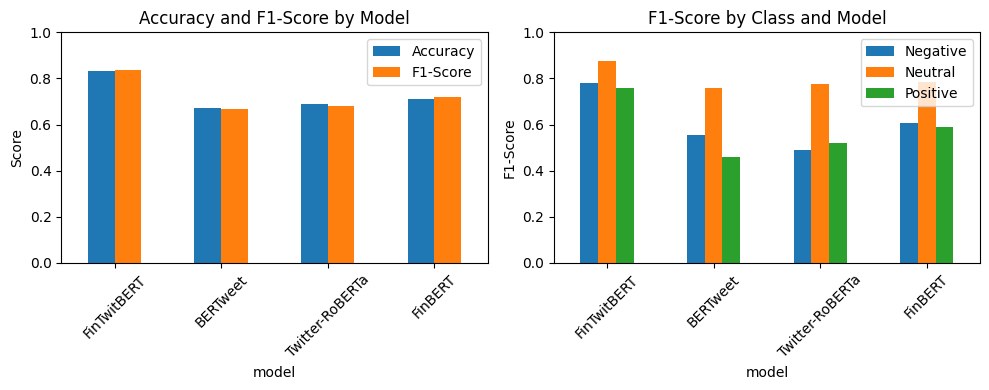

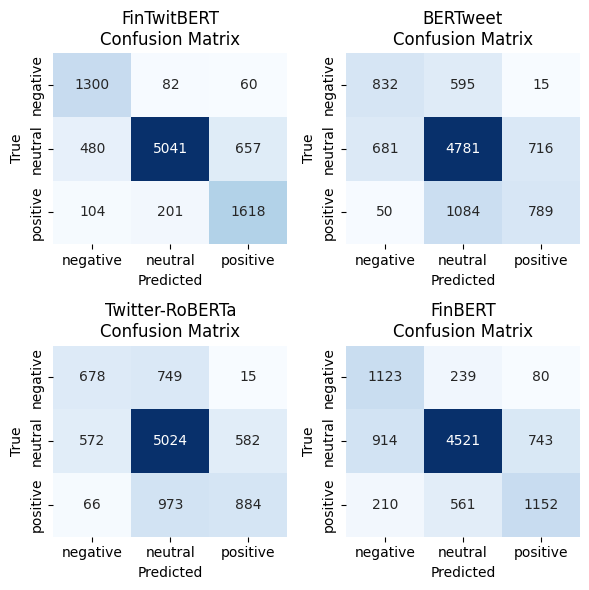


MODELS COMPARISON SUMMARY
             model  accuracy  f1_score  f1_negative  f1_neutral  f1_positive
0      FinTwitBERT    0.8340    0.8387       0.7817      0.8765       0.7600
1         BERTweet    0.6709    0.6658       0.5537      0.7566       0.4583
2  Twitter-RoBERTa    0.6901    0.6823       0.4917      0.7775       0.5194
3          FinBERT    0.7121    0.7202       0.6088      0.7863       0.5911


In [7]:
# Quick dataset check
print("Unique labels:", twitter_finance_df['label'].unique())
print("Distribution:")
print(twitter_finance_df['label'].value_counts().sort_index())

# Models
models = {
    'FinTwitBERT': sentiment_analyzer_fintwit,
    'BERTweet': sentiment_analyzer_bertweet,
    'Twitter-RoBERTa': sentiment_analyzer_twitter,
    'FinBERT': sentiment_analyzer_finance
}

# Run simplified comparison
comparison_df, detailed_results = compare_models_benchmark_simple(
    models, 
    twitter_finance_df,
    text_column='text',
    label_column='label', 
    sample_size=9543
)

print("\n" + "="*60)
print("MODELS COMPARISON SUMMARY")
print("="*60)
print(comparison_df.round(4))